# BlackJack
## A Project Demonstrating the use of Monte Carlo Methods in Reinforcement Learning

BlackJack is a classic casino game played against a dealer. Here, we use reinforcement learning to  
train an agent to play the game with the goal of maximising winrate. OpenAI gym is used to set up
the environment and interact with it.

---

We start off with the usual imports and setting up the environment using the OpenAI gym API.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import os
base = os.path.join(os.getcwd(), r'../')

eps = 1e-9

env = gym.make('Blackjack-v1')

Now we put in settings for how much training is to be done, and also set up some variables to  
help look at our progress while training, once it is complete.

In [2]:
iters = 2 ** 6
games = 2 ** 8

x = np.arange(games)
y = np.zeros(games)

Now to the actual learning. Monte Carlo methods heavily involve random sampling, so to accurately  
judge our results, we will average them over multiple iterations.

In [3]:
observation, info = env.reset()
observation = tuple(int(e) for e in observation)

for iter in range(iters):
    qualities = np.ones((32, 11, 2, 2), np.float64)
    counts = np.zeros((32, 11, 2, 2), np.int32)
    visited = []

    game = 0
    while game < games:
        hitChance = np.exp(qualities[(*observation, 1)]) / np.sum(np.exp(qualities[(*observation, slice(None))]))
        action = 1 if np.random.rand() < hitChance else 0

        prevObservation = observation
        observation, reward, terminated, truncated, info = env.step(action)
        observation = tuple(int(e) for e in observation)

        visited.append((*prevObservation, action))

        if terminated or truncated:
            observation, info = env.reset()
            observation = tuple(int(e) for e in observation)
            y[game] += reward

            for stateAction in visited:
                qualities[stateAction] = (qualities[stateAction] * counts[stateAction] + reward) / (counts[stateAction] + 1)
                counts[stateAction] += 1
            visited = []

            print(f'Iteration {iter + 1} / {iters}, Game {game + 1} / {games}', end=' ' * 128 + '\r')
            game += 1

y /= iters

Our agent is done training! Although it didn't spend much time doing it, we should observe  
a decent improvement over the random gameplay it started with. Let's take a look.

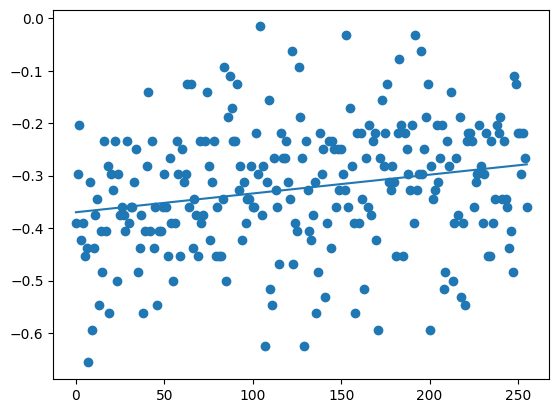

In [4]:
plt.scatter(x, y)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a * x + b)
plt.show()

It definitely improved, but how good is it really? We can find out by doing a before-after comparison.  
Here is the before:

In [5]:
wins, losses, draws = 0, 0, 0

observation, info = env.reset()
observation = tuple(int(e) for e in observation)

games, game = 2 ** 10, 0
while game < games:
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    observation = tuple(int(e) for e in observation)

    if terminated or truncated:
        observation, info = env.reset()
        observation = tuple(int(e) for e in observation)

        if reward == 1: wins += 1
        elif reward == -1: losses += 1
        else: draws += 1

        print(f'Game {game + 1} / {games}', end=' ' * 128 + '\r')
        game += 1

print(end=' ' * 128 + '\r')
print(f'Wins:   {wins   / games * 100:.2f}%')
print(f'Losses: {losses / games * 100:.2f}%')
print(f'Draws:  {draws  / games * 100:.2f}%')

Wins:   27.93%                                                                                                                                  
Losses: 67.68%
Draws:  4.39%


And here is the after.

In [6]:
wins, losses, draws = 0, 0, 0

qualities = np.load(os.path.join(base, r'saves/blackjack_q.npy'))

observation, info = env.reset()
observation = tuple(int(e) for e in observation)

games, game = 2 ** 10, 0
while game < games:
    maxQuality = np.max(qualities[(*observation, slice(None))])

    possibleActions = []
    for action in range(2):
        if np.abs(qualities[(*observation, action)] - maxQuality) <= eps:
            possibleActions.append(action)

    action = np.random.choice(possibleActions)

    observation, reward, terminated, truncated, info = env.step(action)
    observation = tuple(int(e) for e in observation)

    if terminated or truncated:
        observation, info = env.reset()
        observation = tuple(int(e) for e in observation)

        if reward == 1: wins += 1
        elif reward == -1: losses += 1
        else: draws += 1

        print(f'Game {game + 1} / {games}', end=' ' * 128 + '\r')
        game += 1

print(end=' ' * 128 + '\r')
print(f'Wins:   {wins   / games * 100:.2f}%')
print(f'Losses: {losses / games * 100:.2f}%')
print(f'Draws:  {draws  / games * 100:.2f}%')

Wins:   42.77%                                                                                                                                  
Losses: 49.71%
Draws:  7.52%


Here is some gameplay from the agent:

In [7]:
import time

env = gym.make('Blackjack-v1', render_mode='human')

observation, info = env.reset()
observation = tuple(int(e) for e in observation)

games, game = 2 ** 3, 0
while game < games:
    maxQuality = np.max(qualities[(*observation, slice(None))])

    possibleActions = []
    for action in range(2):
        if np.abs(qualities[(*observation, action)] - maxQuality) <= eps:
            possibleActions.append(action)

    action = np.random.choice(possibleActions)

    observation, reward, terminated, truncated, info = env.step(action)
    observation = tuple(int(e) for e in observation)
    time.sleep(4)

    if terminated or truncated:
        observation, info = env.reset()
        observation = tuple(int(e) for e in observation)

        if reward == 1: print('Win :)', end=' ' * 128 + '\r')
        elif reward == -1: print('Loss :(', end=' ' * 128 + '\r')
        else: print('Draw :|', end=' ' * 128 + '\r')

        game += 1

In [8]:
env.close()

---